# Setting up the Network

In [1]:
import numpy as np
from scipy.special import expit as sigmoid
from typing import List, Union, Callable
import sys
import matplotlib.pyplot as plt


In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/jonathanaechtner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


In [2]:
X = np.identity(8)
y = X

In [3]:
def sigmoid_derivative(z: float) -> float:
    return sigmoid(z)*(1-sigmoid(z))

def quadratic_loss(predictions: np.ndarray, actuals: np.ndarray) -> np.ndarray:
    norms = np.apply_along_axis(np.linalg.norm, 0, predictions-actuals)
    return 0.5*np.apply_along_axis(np.power, 0, norms, 2)

def quadratic_loss_derivative(predictions: np.ndarray, actuals: np.ndarray) -> np.ndarray:
    return -(actuals-predictions)

def binary_crossentropy(predictions: np.ndarray, actuals: np.ndarray) -> np.ndarray:
    return actuals*np.log(predictions)+(np.ones(actuals.shape)-actuals)*np.log(np.ones(predictions.shape)-predictions)

def cost_function(loss_function: Callable, predictions: np.ndarray, actuals: np.ndarray, weights: List[np.ndarray], decay_parameter: float) -> float:
    avg_loss: float = np.mean(loss_function(predictions, actuals))
    sum_layers = [np.power(layer_weight, 2).sum() for layer_weight in weights]
    sum_all_weights = sum(sum_layers)
    regularization: float = 0.5*decay_parameter*sum_all_weights
    return avg_loss+regularization

In [4]:
class Layer:
    # declaration of instance variables
    weigths: np.ndarray
    has_bias: bool

    def __init__(self, num_nodes: int, num_nodes_n1: int, include_bias: bool = True, epsilon: float = 0.01) -> None:
        self.weights = np.random.normal(loc=0, scale=np.power(epsilon,2), size=(num_nodes_n1, np.add(num_nodes, include_bias)))
        self.has_bias = include_bias
    
    def print_weights(self) -> None:
        print(self.weights)

In [5]:
class Network:

    # declaration of instance variables
    layers: List[Layer]
    weights: List[np.ndarray]

    def __init__(self, num_nodes: List[int], include_biases: List[bool]) -> None:
        # num_nodes is a list of number of nodes for all layers not counting the bias node
        # TO-DO: code won't work if include_biases != [True, True, False], see prop_forward
        assert (include_biases == [True, True, False]), 'error when initializing Network class: include_bias parameter not available'

        self.layers = [Layer(num_nodes[i], num_nodes[i+1], include_biases[i]) for i in range(len(num_nodes)-1)]
        self.layers.append(Layer(num_nodes[-1], 0, include_biases[-1]))
        self.weights = self.get_weights(form='list')

    def get_weights(self, form: str = 'vector') -> Union[List[np.ndarray], np.ndarray]:
        assert (form in ['vector', 'list']), 'Error in get_weights function: form parameter ill-defined'

        if form == 'vector':
            # returns one np.ndarray with all weights of all layers
            weigth_vector = []
            for layer in self.layers:
                weigth_vector.append(layer.weights)
            return np.asarray(weigth_vector)
        elif form == 'list':
            # returns a list, where list[i] stores the weights between layer i-1 and layer i
            list_of_weights: List[np.ndarray] = []
            for layer in self.layers:
                list_of_weights.append(layer.weights)
            return list_of_weights

    def print_weights(self) -> None:
        print('Printing weights of network:')
        for index, layer in enumerate(self.layers):
            print(f'Layer {index+1}')
            layer.print_weights()

    def prop_forward(self, features: np.ndarray) -> List[np.ndarray]:
        """runs the forward propagation throughout the network.

        Args:
            features (np.ndarray): input features as single samples. Not batches.

        Returns:
            List[np.ndarray]: List of the activations in all layers. The activations in each layer include the Bias.
        """
        # returns a list, where list[i] stores the activations for neurons in layer i+1
        # the activation of a bias node (should the layer have one) is given by the first value in the array and is always =1
        # TO-DO: right now it is hard coded that input layer & hidden layer have a bias node, but output layer has not
        z_2 = np.matmul(self.weights[0], np.append(1, features))
        a_2 = np.apply_along_axis(sigmoid, 0, z_2)
        z_3 = np.matmul(self.weights[1], np.append(1, a_2))
        a_3 = np.apply_along_axis(sigmoid, 0, z_3)
        return [np.append(1, features), np.append(1, a_2), a_3]

    def print_activations(self, features: np.ndarray) -> None:
        print(f'Printing activations for input: {features}')
        for index, array in enumerate(self.prop_forward(features)):
            print(f'Layer {index+1}: {array}')

    def calculate_z(self, num_layer: int, activations: List[np.ndarray]) -> np.ndarray:
        """Function to calculate the z_values for a specific layer in the NN
        Necessary weights are called from self
        Args:
            num_layer (int): integer used to identify the layer to calculate z-values for
            activations (List[np.ndarray]): the activations of the layer

        Returns:
            np.ndarray: Array with shape of the given layer. 
        """
        z = np.dot(self.weights[num_layer-2], activations[num_layer-2])
        return np.dot(self.weights[num_layer-2], activations[num_layer-2])

    def get_deltas(self, X: np.ndarray, y: np.ndarray, activations: List[np.ndarray]=None) -> List[np.ndarray]:
        """Calculate deltas based on the quadratic loss function (as shown in the script by Andrew Ng)

        Args:
            X (np.ndarray): features of training instances
            y (np.ndarray): labels of training instanvces
            activations (List[np.ndarray], optional): [description]. Defaults to None.

        Returns:
            List[np.ndarray]: List of arrays of all the deltas in the network
        """
        # TO-DO: adapt code to accept different cost functions
        # Right now: hard coded to use quadratic loss
        if activations == None:
            activations = self.prop_forward(X)
        deltas = []
        # Fehler: activations != z!!!!
        # deltas_output = -np.multiply((y-activations[-1]), np.apply_along_axis(sigmoid_derivative, 0, activations[-1]))
        deltas_output = -np.multiply((y-activations[-1]), np.apply_along_axis(sigmoid_derivative, 0, self.calculate_z(3, activations)))
        deltas.insert(0, deltas_output)
        for i in range(len(activations)-2):
            # delta = np.multiply(np.matmul(np.transpose(self.weights[-(i+2)]), deltas[-(i+1)]), np.apply_along_axis(sigmoid_derivative, 0, activations[-2]))
            delta = np.multiply(np.matmul(np.transpose(self.weights[-(i+2)][:,1:]), deltas[-(i+1)]), np.apply_along_axis(sigmoid_derivative, 0, self.calculate_z((len(activations)-1-i), activations)))
            # remove 'bias delta', as activation of bias cannot be changed
            deltas.insert(0, delta)
        return deltas

    def partial_derivatives(self, X: np.ndarray, y: np.ndarray, verbose: bool =False) -> List[np.ndarray]:
        """Calculate the partial derivatives throughout the network.

        Args:
            X (np.ndarray): features of training instances
            y (np.ndarray): labels of training instanvces
            verbose (bool, optional): Enable Verbosity for debugging. Defaults to False.

        Returns:
            List[np.ndarray]: List of partial derivatives, where each list item is a np.array with all the partial derivatives needed.
        """
        activations = self.prop_forward(X)
        deltas = self.get_deltas(X, y, activations)
        partial_derivatives = []
        for index in range(len(deltas)):
            if verbose:
                # for testing/debugging purposes
                print(f'Layer {index+1}: dimension deltas {index+2} {deltas[index].shape}, dimension activations {index+1} {activations[index].shape}')
                print(f'activations: {activations[index]}')
                print(f'deltas: {deltas[index]}')
            partial = np.outer(deltas[index], np.transpose(activations[index]))
            if verbose:
                # deltas should be equal to partial derivatives of the bias node
                print(f'Partial of bias: {partial[:,0]}')
            partial_derivatives.append(partial)
        return partial_derivatives

    def update_weights(self, big_delta: List[np.ndarray], regularization_parameter: float, learning_rate: float=0.01) -> None:
        """update self.weights after each iteration.

        Args:
            big_delta (List[np.ndarray]): 
            regularization_parameter (float): Tradeoff between weight size and optimality of the cost function.
            learning_rate (float, optional): The learning rate for the algorithm. Defaults to 0.01.
        """
        for num_layer in range(len(self.weights)):
            self.weights[num_layer] = self.weights[num_layer]-learning_rate*(big_delta[num_layer] + regularization_parameter*self.weights[num_layer])

    def gradient_descent(self, X_train: np.ndarray, y_train: np.ndarray, regularization_parameter: float, learning_rate: float=0.01) -> None:
        """Calculates the forward and backward propagation for given X and y in a single Batch.  Updates the network weights after this run.

        Args:
            X (np.ndarray): features of training instances
            y (np.ndarray): labels of training instanvces
            regularization_parameter (float): Tradeoff between weight size and optimality of the cost function.
            learning_rate (float, optional): The learning rate for the algorithm. Defaults to 0.01.
        """
        big_delta: List[np.ndarray] = [] 
        for index in range(len(self.weights)):
            big_delta.append(np.zeros(self.weights[index].shape))
        for num_instance in range(X_train.shape[0]):
            partials = self.partial_derivatives(X[num_instance], y[num_instance])
            for num_layer in range(len(self.layers)-1):
                big_delta[num_layer] = big_delta[num_layer]+partials[num_layer]
        for num_layer in range(len(self.layers)):
            big_delta[num_layer] = (1/X_train.shape[0])*big_delta[num_layer]
        self.update_weights(big_delta, regularization_parameter, learning_rate)

    def train_network(self, n_iter: int, X_train: np.ndarray, y_train: np.ndarray, regul_param: float, learning_rate: float=0.01) -> None:
        """Runs the gradient_descent function for a given number of iterations. 

        Args:
            n_iter (int): the number of iterations we want to run the algorithm for.
            X (np.ndarray): features of training instances
            y (np.ndarray): labels of training instanvces
            regularization_parameter (float): Tradeoff between weight size and optimality of the cost function.
            learning_rate (float, optional): The learning rate for the algorithm. Defaults to 0.01.
            

        Returns:
            [type]: [description]
        """

        costs = [[], []]
        for iter in range(n_iter):
            
            temp_costs = []            
            
            for instance in X_train:
                act_3 = self.prop_forward(instance)[2].reshape((8,1))
                cos = cost_function(quadratic_loss, act_3, instance, self.weights, regul_param)
                temp_costs.append(cos)
            act_3 = self.prop_forward(instance)[2].reshape((8,1))
            
            costs[0].append(iter)
            costs[1].append(np.mean(temp_costs))
            
            self.gradient_descent(X_train, y_train, regularization_parameter=regul_param, learning_rate=learning_rate)
            
        plt.plot(costs[0], costs[1])
        plt.title(f'learning_rate: {learning_rate}, reg_param: {regul_param}')
        plt.xlabel('iterations')
        plt.ylabel('Quadratic loss')
        plt.show()
        print(f'costs in final iteration: {costs[-1][-1]}')
        return costs

# Experiments 

## first glimpse 
### regularization = 0; learning rate = 1; 50000 iterations

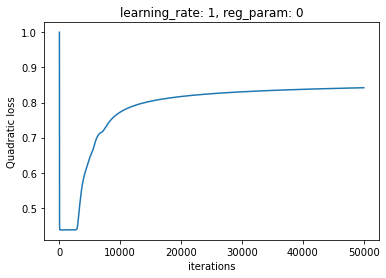

costs in final iteration: 0.8420602272075525
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.00468611 0.01273067 0.23290077]
Layer 3: [9.67280364e-01 2.39674056e-02 1.35435117e-02 2.06428210e-02
 1.07553072e-06 1.44733709e-05 3.73246716e-03 1.86924759e-05]


In [6]:
test_network = Network([8,3,8], [True, True, False])
test_network.train_network(50000, X, y, regul_param=0, learning_rate=1)
test_network.print_activations(X[0])

We can see that the Network is learning to predict the corresponding output for an input. For input [1,0,0,0,0,0,0,0] Layer 3 outputs decent results where the first node approaches 1 while all other nodes approach 0. Given that the results look very promising it's somewhat supprising that the average costs do actually increase. One possible solution for this would be that the costfunction in on itself is not working correctly. Which seems counterintuitive as the activations of layer 3 approach optimum. As this graph gives little to no information of the influence of different parameters further experiments will be conducted. It seems that the error approaches 7/8.

## regularization parameters.
### different regularization values; learning rate = 1; 10000 iterations
As we can see convergance takes different amounts of time for different regularization parameters. Generally it can be said that the higher the regularization parameter goes the later convergence happens.
Furthermore it's important to notice that an increasing regularization parameter influences the hight of the plot. Which means that we can not compare plots of different regularization parameters directly.
However, all of the plots fit the overall shape of the initially plotted graph. They only seem to show different details. 
The first minimum in the graph describes a setting where all output nodes return the same value. One theory is that this is implicit by the way the cost function is designed. In a setting where all samples are provided equally often and greater weights are peanalized it is a minimum to simply set all values same and minimize that. Therefore it's not supprising that these values approach 1/8. The process to this state can be best observed in the plot for regularization parameter = 0.01

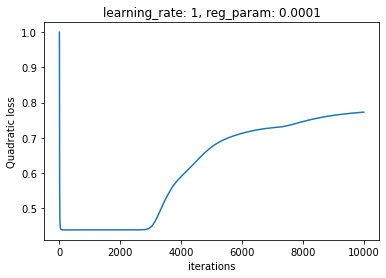

costs in final iteration: 0.7728796941400351
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.91604118 0.03227275 0.90585519]
Layer 3: [8.78921791e-01 4.75537083e-02 7.13221354e-02 3.32705667e-05
 6.52639294e-04 6.00060909e-02 8.22717952e-05 9.87171296e-02]


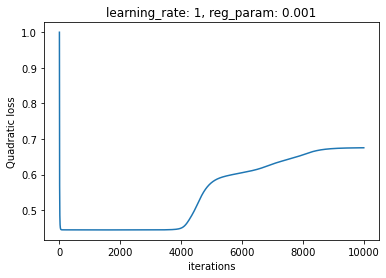

costs in final iteration: 0.6752890109932744
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.49707582 0.08205966 0.08173225]
Layer 3: [0.64651843 0.1681521  0.16301314 0.11659418 0.16893526 0.16626691
 0.11179789 0.02033338]


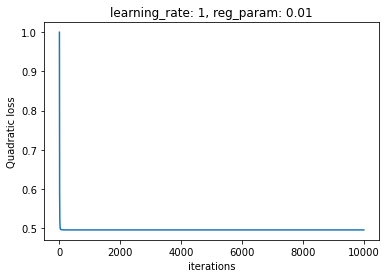

costs in final iteration: 0.4950023836384062
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.65223148 0.65223148 0.65223148]
Layer 3: [0.17302872 0.17302872 0.17302872 0.17302872 0.17302872 0.17302872
 0.17302872 0.17302872]


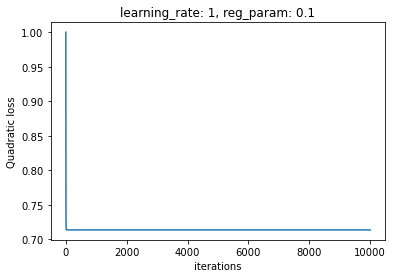

costs in final iteration: 0.713815713038938
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.55091266 0.55091266 0.55091266]
Layer 3: [0.31436516 0.31436516 0.31436516 0.31436516 0.31436516 0.31436516
 0.31436516 0.31436516]


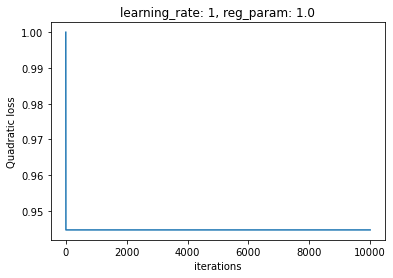

costs in final iteration: 0.9446381284014312
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.50199617 0.50199617 0.50199617]
Layer 3: [0.46315582 0.46315582 0.46315582 0.46315582 0.46315582 0.46315582
 0.46315582 0.46315582]


In [7]:
for reg_par in np.logspace(-4,0,5):
    test_network = Network([8,3,8], [True, True, False])
    test_network.train_network(10000, X, y, regul_param=reg_par, learning_rate=1)
    test_network.print_activations(X[0])

## learning rate
### different learning rates; regularization 0.001; 10000 iterations
As can be observed a difference in learning rates mainly influences the number of iterations till we find convergance. If we look at the last two plots it can be observed that the graph seems to become less smoth, which makes sense as we'd assume the changes between any two iteration to increase with an increasing learning rate.
Lastly it's remarkable that the plots from this and the previous experiment for the parameters learning rate = 1 and regularization parameter = 0.001 do not allign perfectly. The general shape is quite similar and it can be observed that hte error rises at around the same number of iterations in both trials. It can be assumed that this because of the 

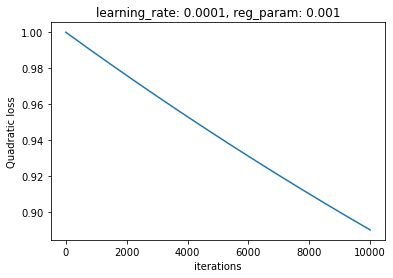

costs in final iteration: 0.8898467881984506
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.50100867 0.50113567 0.50113005]
Layer 3: [0.46125706 0.4612502  0.46124103 0.46125448 0.46130033 0.4613149
 0.4612468  0.46121553]


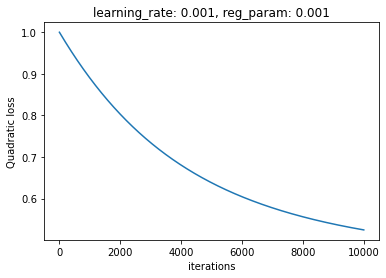

costs in final iteration: 0.5244179135714881
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.54165807 0.54165291 0.54155022]
Layer 3: [0.27058123 0.27058132 0.2705888  0.27057562 0.27058083 0.27057586
 0.27057318 0.27057767]


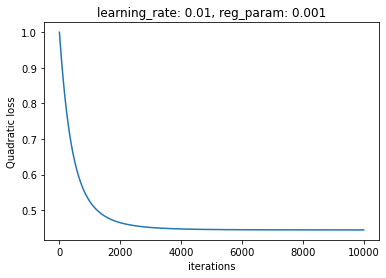

costs in final iteration: 0.4446100410512752
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.62731182 0.62729275 0.62726833]
Layer 3: [0.13444096 0.13444048 0.13444118 0.13444094 0.13444092 0.13444043
 0.13444082 0.13444113]


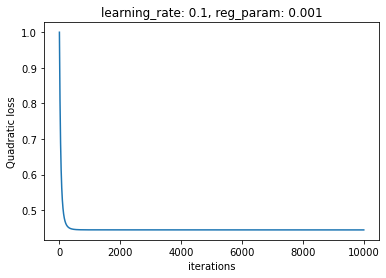

costs in final iteration: 0.44442658125622236
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.66905728 0.6694796  0.669164  ]
Layer 3: [0.13188704 0.13188837 0.13188752 0.1318875  0.13188751 0.13188784
 0.13188745 0.13188737]


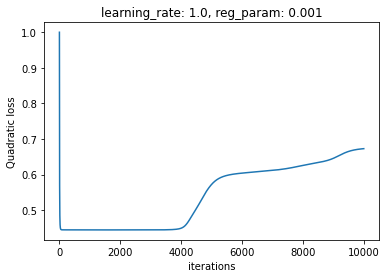

costs in final iteration: 0.6727602136119896
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.43361603 0.43416976 0.4233318 ]
Layer 3: [0.14219278 0.11844028 0.1248428  0.13824569 0.15189441 0.1156087
 0.11460552 0.11940147]


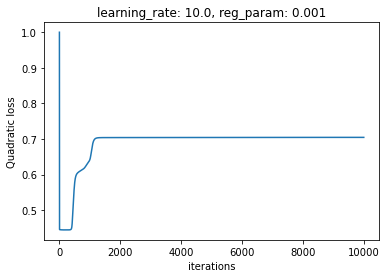

costs in final iteration: 0.7045279956795862
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.85882672 0.87683811 0.08663356]
Layer 3: [0.64487139 0.19431479 0.02839172 0.17615309 0.15739096 0.12084254
 0.03071651 0.00638428]


In [8]:
for learn_rate in np.logspace(-4,1,6):
    test_network = Network([8,3,8], [True, True, False])
    test_network.train_network(10000, X, y, regul_param=0.001, learning_rate=learn_rate)
    test_network.print_activations(X[0])

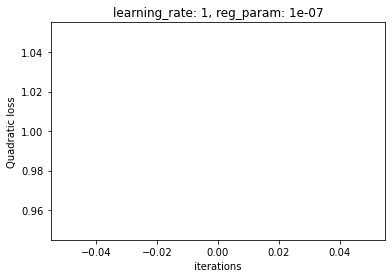

costs in final iteration: 0.9999828878778132


[[0], [0.9999828878778132]]

In [9]:
test_network = Network([8,3,8], [True, True, False])
test_network.train_network(1, X, y, regul_param=1e-7, learning_rate=1)

## initial weights
to modify the initial weights some minor changes are needed in the Layer class. For the previous experiments the initial weights were drawn from a normal distribution centered around 0 and standard deviation of 0.01^2.
In a first attemp the mean of this normal distribution is shifted to 0.5.
To enable comparison the same parameter will be used as for the experiment labeled 'first glimpse'

In [10]:
class Layer:
    weigths: np.ndarray
    has_bias: bool

    def __init__(self, num_nodes: int, num_nodes_n1: int, include_bias: bool = True, epsilon: float = 0.01) -> None:
        self.weights = np.random.normal(loc=0.5, scale=np.power(epsilon,2), size=(num_nodes_n1, np.add(num_nodes, include_bias)))
        self.has_bias = include_bias
    
    def print_weights(self) -> None:
        print(self.weights)

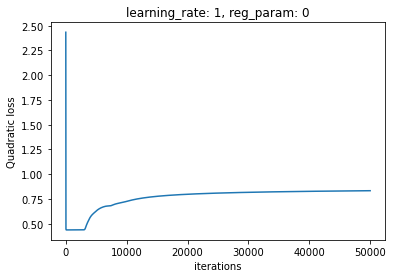

costs in final iteration: 0.8335754280870163
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.00444937 0.99479889 0.46091352]
Layer 3: [9.55429368e-01 1.40621071e-07 3.27234960e-02 9.20983376e-03
 2.97511041e-02 2.48571390e-04 8.44532415e-06 6.75300332e-11]


In [11]:
test_network = Network([8,3,8], [True, True, False])
test_network.train_network(50000, X, y, regul_param=0, learning_rate=1)
test_network.print_activations(X[0])

Secondly this experiment is repeated with a standard deviation of 0.3 and a mean of 0.

In [12]:
class Layer:
    weigths: np.ndarray
    has_bias: bool

    def __init__(self, num_nodes: int, num_nodes_n1: int, include_bias: bool = True, epsilon: float = 0.01) -> None:
        self.weights = np.random.normal(loc=0, scale=0.3, size=(num_nodes_n1, np.add(num_nodes, include_bias)))
        self.has_bias = include_bias
    
    def print_weights(self) -> None:
        print(self.weights)

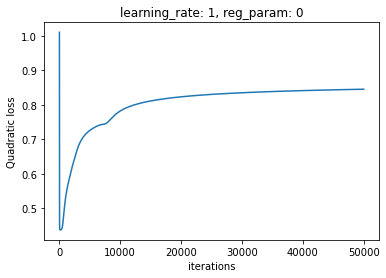

costs in final iteration: 0.8453343824440726
Printing activations for input: [1. 0. 0. 0. 0. 0. 0. 0.]
Layer 1: [1. 1. 0. 0. 0. 0. 0. 0. 0.]
Layer 2: [1.         0.90579092 0.00515203 0.04691745]
Layer 3: [9.73457581e-01 2.01971407e-02 1.63488287e-02 3.33146599e-05
 6.22914112e-06 9.15873050e-06 2.05620025e-09 2.35149234e-02]


In [13]:
test_network = Network([8,3,8], [True, True, False])
test_network.train_network(50000, X, y, regul_param=0, learning_rate=1)
test_network.print_activations(X[0])

the direct comparison of all three cases where 50000 iterations were run reveals that the different initial weights have hardly any relevance for the final results. That said it's can be easily seen how convergence happens much quicker for the last example with higher standard deviation, than for the 'normal' case or the shifted mean. Therefore it's concluded that the initial weights have a tremendous influence of the number of iterations that're to be run till convergence.

## Final remarks
It has been shown that our algorithm works as intended and that the results after a number of iterations (which number depends on the exact parameters) are passable.